# Suggestion to Reader: Scroll to Bottom _First_

There's one cell that wraps everything together in a concise, functional demo.

In [1]:
%matplotlib notebook

import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitti_dir = 'kitti'
kitti_sequence = '04'

kitti = pykitti.odometry(kitti_dir, kitti_sequence)
K = kitti.calib.K_cam0
imgs = kitti.cam0
poses = kitti.poses

<IPython.core.display.Javascript object>


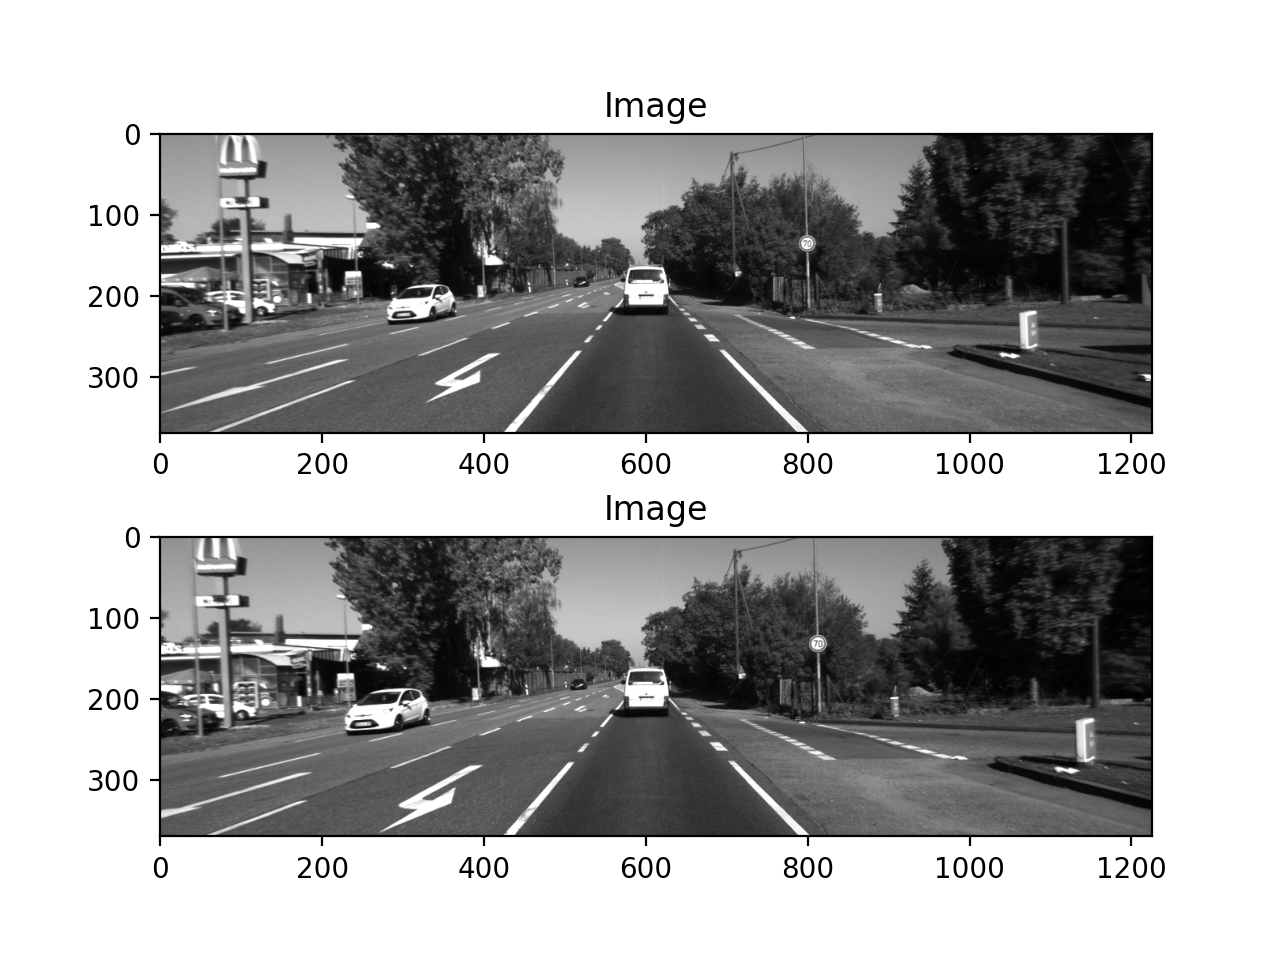

In [2]:
img1 = np.array(next(imgs))
img2 = np.array(next(imgs))
img3 = np.array(next(imgs))

plt.subplot(2, 1, 1)
plt.imshow(img1, cmap='gray')
plt.title('Image')
plt.show()
plt.subplot(2, 1, 2)
plt.imshow(img2, cmap='gray')
plt.title('Image')
plt.show()

## Detect Features

<IPython.core.display.Javascript object>


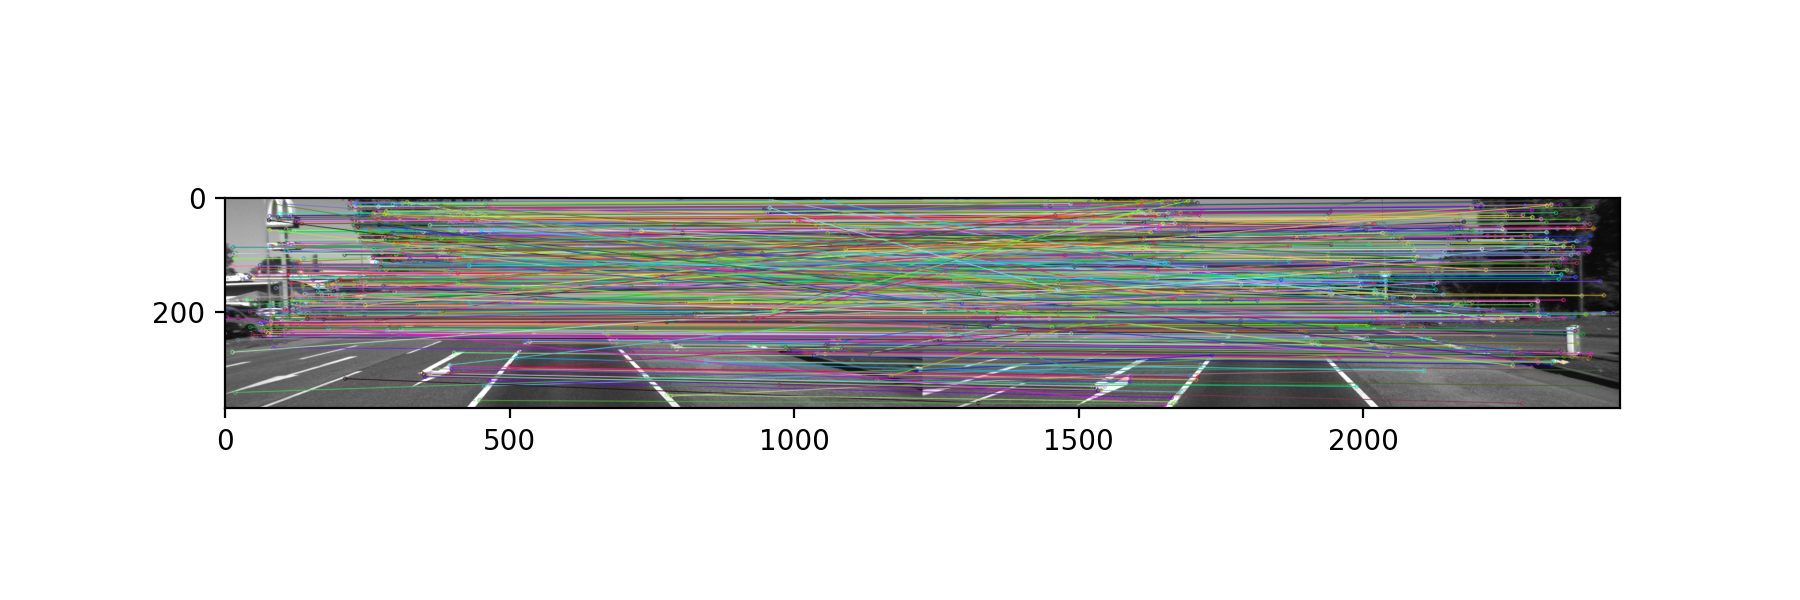

Keeping 558/1481 points that match the fundamental matrix
E: [[-5.36489122e-01  9.44261270e+02  1.47976402e+01]
 [-9.43830215e+02  4.81256752e-01 -4.83846363e+00]
 [-1.63089261e+01  4.90875889e+00 -6.79652354e-03]]


In [3]:
def detect_matches_and_E(img1, img2, draw=True):
	# Find Matches
	# From: https://stackoverflow.com/a/33670318
	sift = cv2.SIFT_create()
	kp1, des1 = sift.detectAndCompute(img1, None)
	kp2, des2 = sift.detectAndCompute(img2, None)
	bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
	matches = bf.match(des1, des2)
	matches = sorted(matches, key=lambda x: x.distance)

	if draw:
		match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
		plt.figure(figsize=(9, 3))
		plt.imshow(match_img)
		plt.show()

	# Find Points
	# From book
	imgpts1 = []
	imgpts2 = []
	for match in matches:
		imgpts1.append(kp1[match.queryIdx].pt)
		imgpts2.append(kp2[match.trainIdx].pt)
	
	points1 = np.array(imgpts1)
	points2 = np.array(imgpts2)
	
	F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 100000)
	E = K.T @ F @ K
	
	if draw:
		print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")

	status_mask = status_mask[:, 0] == 1
	points1 = points1[status_mask]
	points2 = points2[status_mask]

	return points1, points2, matches, E

points1, points2, matches, E = detect_matches_and_E(img1, img2)

print("E:", E)

<IPython.core.display.Javascript object>


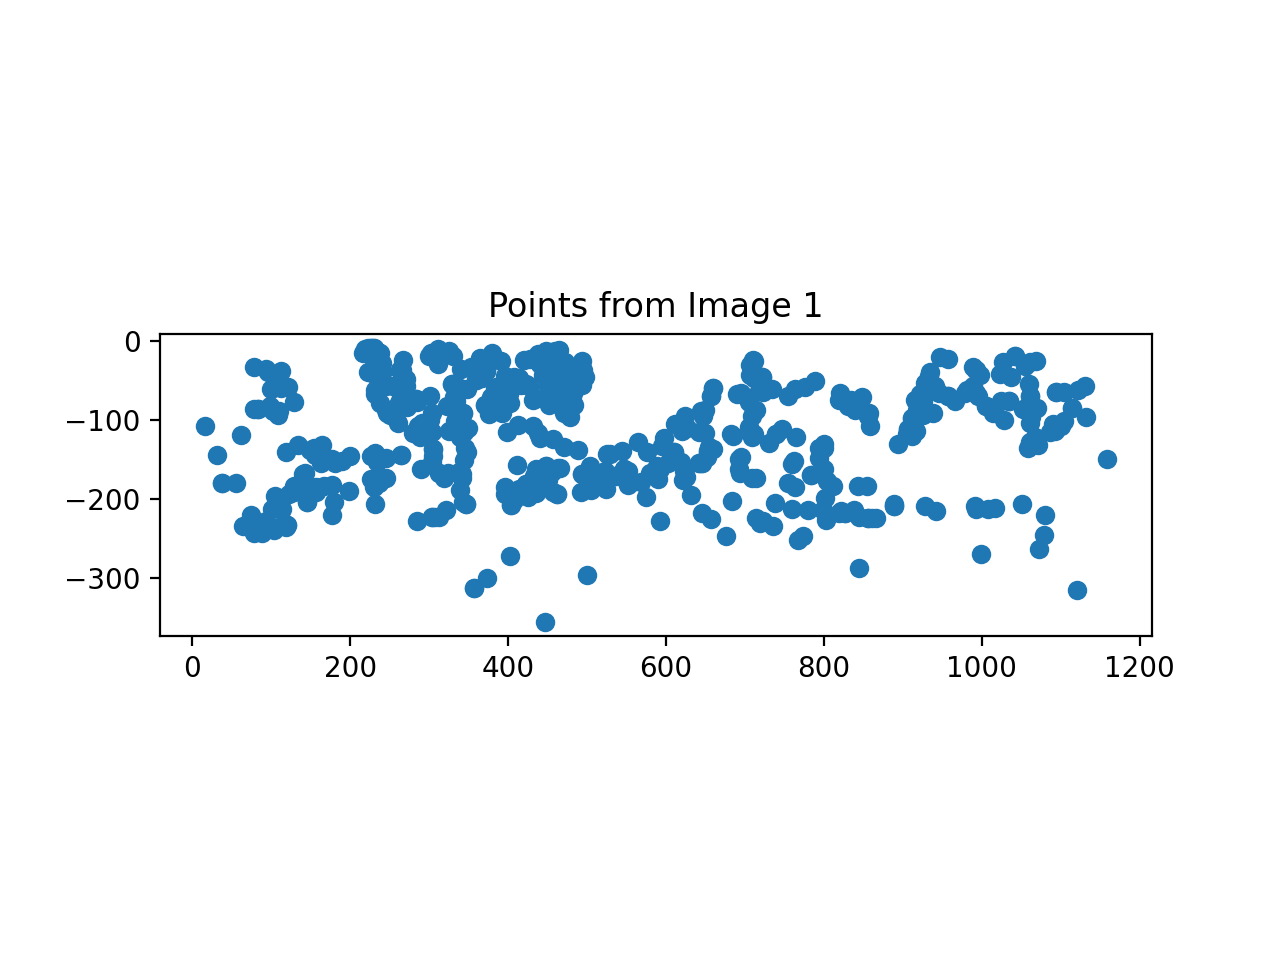

In [4]:
plt.figure()
plt.title('Points from Image 1')
plt.scatter(points1[:, 0], -1 * points1[:, 1])
plt.gca().set_aspect('equal')
plt.show()

In [5]:
# From book
def P_from_E(E):
	# ???: It seems like all the data here is in w, which we
	w, u, vt = cv2.SVDecomp(E)

	W = np.array([
		[0, -1 , 0],
		[1, 0, 0],
		[0, 0, 1]
	])

	R = u @ W @ vt
	t = u[:, 2]

	assert np.abs(np.linalg.det(R)) - 1.0 <= 1e-07, "det(R) != ±1.0, this isn't a rotation matrix!"

	P = np.hstack((R, t[:, np.newaxis]))
	return P

P1 = P_from_E(E)
# P0 is assumed to be fixed
P0 = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])

print("P0:", P0)
print("P1:", P1)

P0: [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
P1: [[ 9.99946722e-01 -1.37199197e-04  1.03215552e-02  5.18886821e-03]
 [-2.02884292e-04  9.99457291e-01  3.29405998e-02  1.72737524e-02]
 [ 1.03204731e-02  3.29409389e-02 -9.99404014e-01 -9.99837333e-01]]


## Triangulation

In [6]:
# From book
def triangulate(
	# NOTE: u and u1 need to be normalized (multiplied by K, or P0 and P1 do)
	u0: np.array, # point in image 1: (x, y, 1)
	P0: np.array, # camera 1 matrix
	u1: np.array, # point in image 2: (x, y, 1)
	P1: np.array, # camera 2 matrix
):
	# XXX: I don't quite understand this
	A = np.array([
		[u0[0]*P0[2,0]-P0[0,0], u0[0]*P0[2,1]-P0[0,1], u0[0]*P0[2,2]-P0[0,2]],
		[u0[1]*P0[2,0]-P0[1,0], u0[1]*P0[2,1]-P0[1,1], u0[1]*P0[2,2]-P0[1,2]],
		[u1[0]*P1[2,0]-P1[0,0], u1[0]*P1[2,1]-P1[0,1], u1[0]*P1[2,2]-P1[0,2]],
		[u1[1]*P1[2,0]-P1[1,0], u1[1]*P1[2,1]-P1[1,1], u1[1]*P1[2,2]-P1[1,2]]
	])

	B = np.array([
		-(u0[0]*P0[2, 3]-P0[0, 3]),
		-(u0[1]*P0[2, 3]-P0[1, 3]),
		-(u1[0]*P1[2, 3]-P1[0, 3]),
		-(u1[1]*P1[2, 3]-P1[1, 3])
	])

	_, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
	return np.array([*X[:, 0], 1.0])


In [7]:
from collections import namedtuple

class CloudPoint(namedtuple('CloudPoint', ['point_3d', 'point_2d_2'])):
	def __eq__(self, other):
		return np.array_equal(self.point_3d, other.point_3d) and np.array_equal(self.point_2d_2, other.point_2d_2)

# From book
def triangulate_points(
	pt_set1: np.array,
	pt_set2: np.array,
	K: np.array,
	P0: np.array,
	P1: np.array,
):
	Kinv = np.linalg.inv(K)
	point_cloud = []
	reproj_error = []
	
	for i in range(len(pt_set1)):
		# Convert to normalized, homogeneous coordinates
		u0 = Kinv @ np.array([*pt_set1[i], 1.0])
		u1 = Kinv @ np.array([*pt_set2[i], 1.0])

		# Triangulate
		X = triangulate(u0, P0, u1, P1)
		cloudpoint = CloudPoint(X[0:3], pt_set2[i])

		if cloudpoint in point_cloud:
			continue

		# Calculate reprojection error
		reproj = K @ P1 @ X
		reproj_normalized = reproj[0:1] / reproj[2]
		reproj_error.append(np.linalg.norm(reproj_normalized))
		point_cloud.append(cloudpoint)
	
	# Return mean reprojection error
	return np.mean(reproj_error), point_cloud


err, point_cloud = triangulate_points(points1, points2, K, P0, P1)
print("Mean reprojection error:", err)


Mean reprojection error: 536.4048928095128


<IPython.core.display.Javascript object>


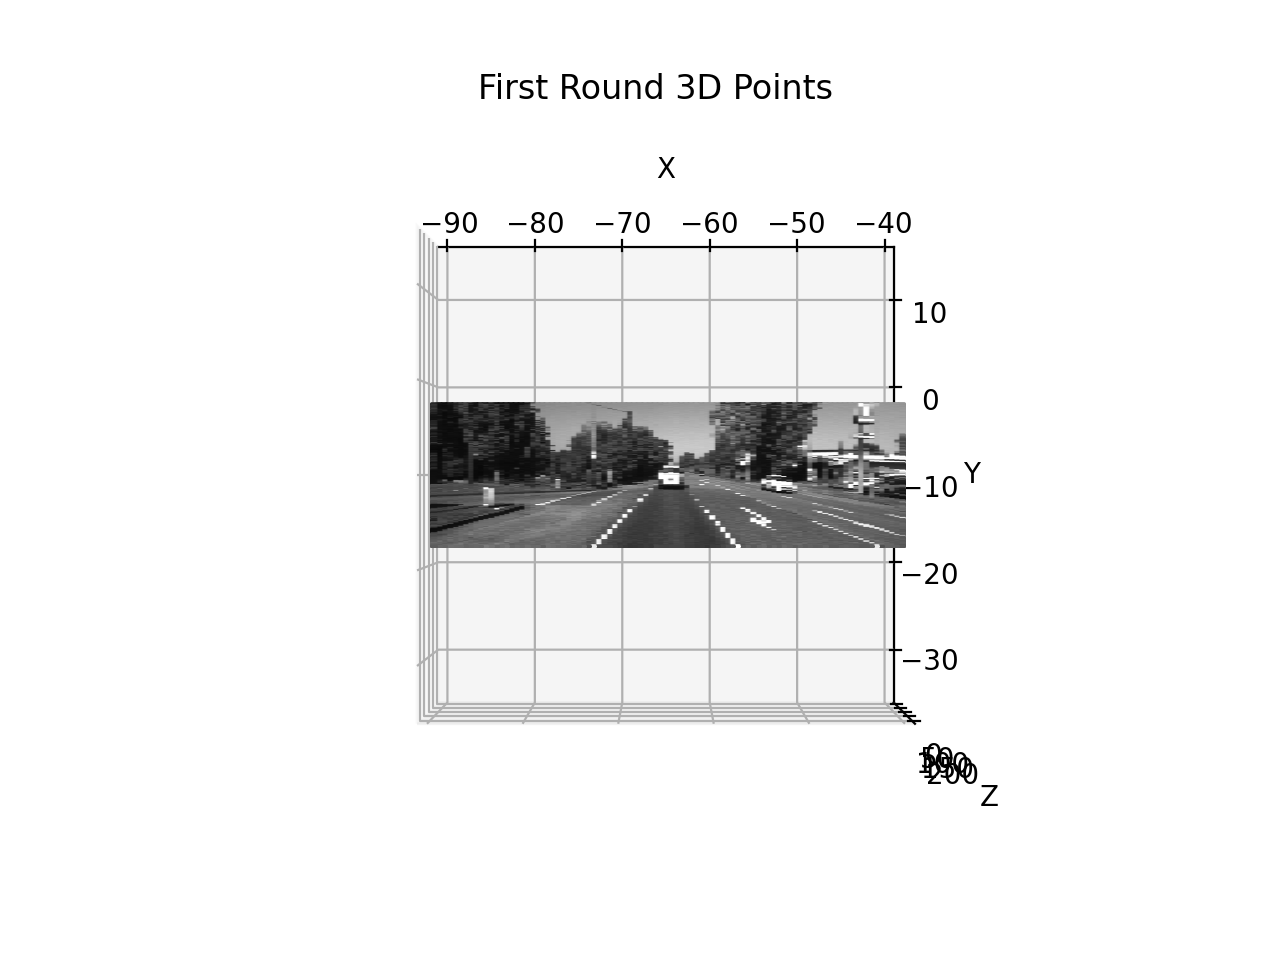

img_scaled.shape: (613, 185)
X width/min/center/max: -25.0/-40.0/-65.0/-90.0, Y with/min/center/max: -7.544861337683524/-2.455138662316476/-10.0/-17.544861337683525
shapes: X1: (613, 185) Y1: (613, 185) Z1: (613, 185) img_scaled_rot: (613, 185) cmap: (613, 185, 3)


In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for cp in point_cloud:
	ax.scatter(*cp.point_3d)

# Scale image for performanc
img_scaled = cv2.resize(img1, dsize=(img1.shape[0] // 2, img1.shape[1] // 2), interpolation=cv2.INTER_CUBIC)
# img_scaled = np.rot90(img_scaled)

print("img_scaled.shape:", img_scaled.shape)
    
# FIXME: These are all guesses
X_CENTER = -65.
Y_CENTER = -10.
WIDTH = -25.

biggest_axis = max(img_scaled.shape)

X_WIDTH = WIDTH * (img_scaled.shape[0] / biggest_axis)
Y_WIDTH = WIDTH * (img_scaled.shape[1] / biggest_axis)

X_MIN = X_CENTER - X_WIDTH
X_MAX = X_CENTER + X_WIDTH
Y_MIN = Y_CENTER - Y_WIDTH
Y_MAX = Y_CENTER + Y_WIDTH

print(f"X width/min/center/max: {X_WIDTH}/{X_MIN}/{X_CENTER}/{X_MAX}, Y with/min/center/max: {Y_WIDTH}/{Y_MIN}/{Y_CENTER}/{Y_MAX}")
    
ax.set_title('First Round 3D Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(X_CENTER - WIDTH, X_CENTER + WIDTH)
ax.set_ylim(Y_CENTER - WIDTH, Y_CENTER + WIDTH)


# 10 is equal length of x and y axises of your surface
stepX, stepY = (X_MAX - X_MIN) / img_scaled.shape[1], (Y_MAX - Y_MIN) / img_scaled.shape[0]

X1 = np.arange(X_MIN, X_MAX, stepX)
Y1 = np.arange(Y_MIN, Y_MAX, stepY)
X1, Y1 = np.meshgrid(X1, Y1)
Z1 = np.zeros_like(X1)
Z1.fill(215)

img_scaled_rot = img_scaled #np.rot90(img_scaled_rot)

cmap = np.zeros((*img_scaled_rot.shape, 3))
cmap[:, :, 0] = img_scaled_rot / 255.
cmap[:, :, 1] = img_scaled_rot / 255.
cmap[:, :, 2] = img_scaled_rot / 255.

print("shapes:", "X1:", X1.shape, "Y1:", Y1.shape, "Z1:", Z1.shape, "img_scaled_rot:", img_scaled_rot.shape, "cmap:", cmap.shape)

# stride args allows to determine image quality 
# stride = 1 work slow
ax.plot_surface(X1, Y1, Z1, rstride=2, cstride=2, shade=False, facecolors=cmap)

ax.view_init(90, 90)

plt.show()

From the above image, I think it's working although the visualization clearly isn't right.

In [9]:
def P_from_PnP(point_cloud, points2, K):
	# Not really from book, because the book's implementation of this is incomprehensible
	success, rvec, t, inliers = cv2.solvePnPRansac(np.array([p.point_3d for p in point_cloud]), points2, K, None)
	assert success, "PnP failed!"

	R, _ = cv2.Rodrigues(rvec)

	P = np.hstack((R, t))
	return P, R, t

In [10]:
P1_new, R, t = P_from_PnP(point_cloud, points2, K)
print("Difference between E-based P1 and PnP-based P1 (should be ~0, since it's the same data):", np.sum(P1 - P1_new))

error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/solvepnp.cpp:241: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'


## Try a 3rd Frame

<IPython.core.display.Javascript object>


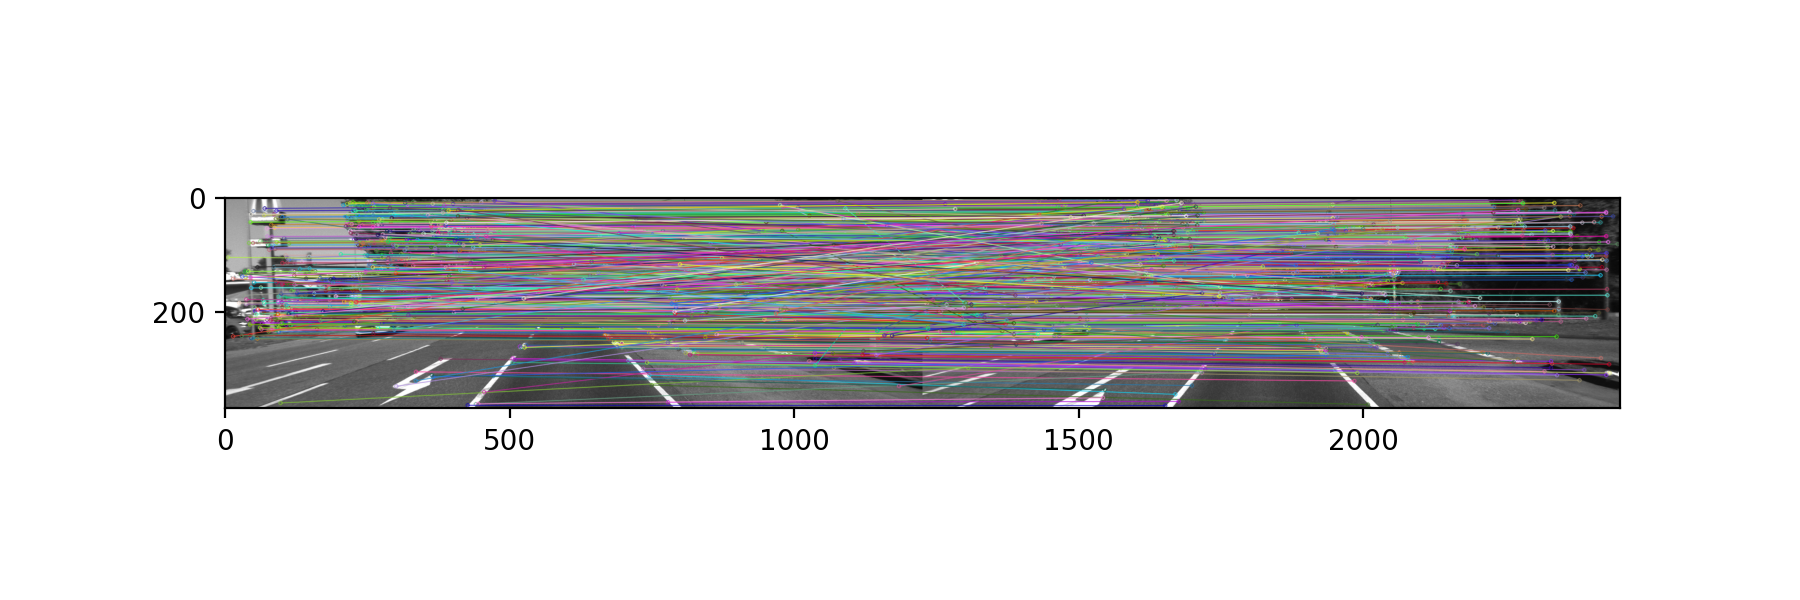

Keeping 550/1464 points that match the fundamental matrix
Keeping 214/550 frame3 points, others weren't present in frames1/2


(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]),
 array([[ 9.99946722e-01, -1.37199197e-04,  1.03215552e-02,
          5.18886821e-03],
        [-2.02884292e-04,  9.99457291e-01,  3.29405998e-02,
          1.72737524e-02],
        [ 1.03204731e-02,  3.29409389e-02, -9.99404014e-01,
         -9.99837333e-01]]),
 array([[-9.99686988e-01, -8.81748178e-04,  2.50029811e-02,
          1.35339020e-02],
        [ 6.67649850e-04, -9.99963054e-01, -8.56996745e-03,
         -4.12765977e-03],
        [ 2.50096139e-02, -8.55059171e-03,  9.99650642e-01,
          9.74054393e-01]]))

In [11]:
# I made this part up, although it's an amalgamation of code from above which came from other places
points2, points3, matches, _ = detect_matches_and_E(img2, img3)

points3_valid = []

for point2, point3 in zip(points2, points3):
	for cp in point_cloud:
		if np.array_equal(point2, cp.point_2d_2):
			points3_valid.append((cp, point3))
			break

print(f"Keeping {len(points3_valid)}/{len(points3)} frame3 points, others weren't present in frames1/2")

P2, R, t = P_from_PnP((cp for cp, _ in points3_valid), np.array([point3 for cp, point3 in points3_valid]), K)

P0, P1, P2

In [12]:
success, rvec, t, inliers = cv2.solvePnPRansac(np.array([cp.point_3d for cp, point3 in points3_valid]), np.array([point3 for cp, point3 in points3_valid]), K, None)
assert success, "PnP failed!"

R, _ = cv2.Rodrigues(rvec)

P2 = np.hstack((R, t))
P0, P1, P2

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]),
 array([[ 9.99946722e-01, -1.37199197e-04,  1.03215552e-02,
          5.18886821e-03],
        [-2.02884292e-04,  9.99457291e-01,  3.29405998e-02,
          1.72737524e-02],
        [ 1.03204731e-02,  3.29409389e-02, -9.99404014e-01,
         -9.99837333e-01]]),
 array([[-9.99686988e-01, -8.81748178e-04,  2.50029811e-02,
          1.35339020e-02],
        [ 6.67649850e-04, -9.99963054e-01, -8.56996745e-03,
         -4.12765977e-03],
        [ 2.50096139e-02, -8.55059171e-03,  9.99650642e-01,
          9.74054393e-01]]))

### Re-triangulate

In [13]:
err, point_cloud = triangulate_points(points2, points3, K, P1, P2)
print("Mean reprojection error:", err)

Mean reprojection error: 533.9320265994398


In [14]:
# Helper
def normalize(v, *args, **kwargs):
    return v / np.linalg.norm(v, *args, **kwargs)

## Continuous

In [ ]:
# I made this part up, although it's an amalgamation of code from above which came from other places
# This cell is self-contained from a state perspective, but not a logic one
from itertools import islice

### Setup ###
K = kitti.calib.K_cam0
imgs = (np.array(img) for img in kitti.cam0)
ground_truth_poses = kitti.poses

img0 = next(imgs)
img1 = next(imgs)

points0, points1, matches, E = detect_matches_and_E(img0, img1)
# P0 is assumed to be fixed to start
P0 = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])
P1 = P_from_E(E)
Ps = [P0, P1]
Es = [E]
cur_pose = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
poses = [cur_pose]
err, point_cloud = triangulate_points(points0, points1, K, P0, P1)




### Graph ###
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# for cp in point_cloud:
# 	ax.scatter(*cp.point_3d)

# ax.set_title('First Round 3D Points')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()

### Run ###

for img in imgs:
	img0, img1 = img1, img
	points0, points1, matches, E = detect_matches_and_E(img0, img1, draw=False)
	Es.append(E)
	points1_valid = []

	for point0, point1 in zip(points0, points1):
		for cp in point_cloud:
			if np.array_equal(point0, cp.point_2d_2):
				points1_valid.append((cp, point1))
				break
	
	print(f"Keeping {len(points1_valid)}/{len(points1)} new points, others weren't present in previous frame.")

	P0 = P1
	P1, R, t = P_from_PnP((cp for cp, _ in points1_valid), np.array([point1 for cp, point1 in points1_valid]), K)
	Ps.append(P1)
	P1_fixed = np.vstack((P1, [0,0,0,1]))
	print(P1_fixed, cur_pose)
	cur_pose = (P1_fixed @ cur_pose)
	poses.append(cur_pose)

	err, point_cloud = triangulate_points(points0, points1, K, P0, P1)
	print("Mean reprojection error:", err)


<IPython.core.display.Javascript object>

Keeping 558/1481 points that match the fundamental matrix
Keeping 214/550 new points, others weren't present in previous frame.
[[-9.99686988e-01 -8.81748178e-04  2.50029811e-02  1.35339020e-02]
 [ 6.67649850e-04 -9.99963054e-01 -8.56996745e-03 -4.12765977e-03]
 [ 2.50096139e-02 -8.55059171e-03  9.99650642e-01  9.74054393e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Mean reprojection error: 533.9320265994398
Keeping 217/566 new points, others weren't present in previous frame.
[[-9.98006510e-01  2.57195476e-05  6.31110528e-02  3.29964730e-02]
 [-2.38687396e-04 -9.99994303e-01 -3.36695658e-03  1.79819654e-04]
 [ 6.31106067e-02 -3.37530840e-03  9.98000831e-01  9.47585340e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-9.99686988e-01 -8.81748178e-04  2.50029811e-02  1.35339020e-02]
 [ 6.67649850e-04 -9.99963054e-01 -8.56996745e-03 -4.12765977e-03]
 [ 2.50096139e-02 -8.55059171e-03  9.99650

Keeping 168/462 new points, others weren't present in previous frame.
[[-0.85636718  0.0401531   0.51480384  0.23718794]
 [-0.05767178 -0.99817184 -0.0180817   0.00996017]
 [ 0.51313665 -0.04517423  0.8571173   0.56319487]
 [ 0.          0.          0.          1.        ]] [[ 0.89661046 -0.35968196  0.25829938  3.36444389]
 [ 0.37682871  0.92609906 -0.01845702 -0.25906386]
 [-0.23257215  0.11388338  0.96588859 12.17663107]
 [ 0.          0.          0.          1.        ]]
Mean reprojection error: 472.8914594061829
Keeping 170/470 new points, others weren't present in previous frame.
[[-0.84583253  0.04315149  0.53170036  0.24362641]
 [-0.06112623 -0.99799784 -0.01624498  0.01082711]
 [ 0.52993482 -0.04624137  0.84677673  0.5416389 ]
 [ 0.          0.          0.          1.        ]] [[-0.87242596  0.40383317  0.27530293  3.6141628 ]
 [-0.42364363 -0.9057217  -0.01393821 -0.14565721]
 [ 0.24371913 -0.12879039  0.96125648 12.73811849]
 [ 0.          0.          0.          1.        

Keeping 192/494 new points, others weren't present in previous frame.
[[-0.81978465  0.06932996  0.56845975  0.25690754]
 [-0.06948116 -0.99735288  0.02143836  0.03092776]
 [ 0.56844129 -0.0219224   0.8224317   0.38435147]
 [ 0.          0.          0.          1.        ]] [[-2.41498258e-01  9.23870241e-01  2.96887807e-01  6.06969265e+00]
 [-9.67360035e-01 -2.53400475e-01  1.66188902e-03 -6.36326286e-03]
 [ 7.67668812e-02 -2.86796056e-01  9.54910922e-01  1.95069425e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 449.13417527914527
Keeping 178/433 new points, others weren't present in previous frame.
[[-0.8194918   0.06866704  0.56896223  0.25719994]
 [-0.06867037 -0.9974084   0.02146764  0.03108847]
 [ 0.56896183 -0.02147829  0.8220834   0.37492337]
 [ 0.          0.          0.          1.        ]] [[ 1.74548418e-01 -9.37974898e-01  2.99559578e-01  6.36953724e+00]
 [ 9.83224651e-01  1.82389682e-01 -1.81387391e-03  3.37417738e-02]
 [-

Keeping 164/371 new points, others weren't present in previous frame.
[[-0.81873109  0.05634933  0.57140543  0.25991672]
 [-0.06082721 -0.99808467  0.01127094  0.02874323]
 [ 0.57094611 -0.02552913  0.82059052  0.25222373]
 [ 0.          0.          0.          1.        ]] [[ 6.27242036e-01  7.19600874e-01  2.97895973e-01  7.79543547e+00]
 [-7.52976975e-01  6.58034056e-01 -4.10569864e-03 -1.73128655e-01]
 [-1.98980160e-01 -2.21733542e-01  9.54589510e-01  2.46199502e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 418.64218091448623
Keeping 169/387 new points, others weren't present in previous frame.
[[-0.81907562  0.05683305  0.5708635   0.25979655]
 [-0.06096626 -0.99806901  0.01188959  0.02911706]
 [ 0.57043689 -0.02506494  0.8209589   0.24307088]
 [ 0.          0.          0.          1.        ]] [[-6.69670646e-01 -6.78779574e-01  3.01329580e-01  7.93576886e+00]
 [ 7.11138701e-01 -7.03044166e-01 -3.26322545e-03  4.85566590e-03]
 [ 

Keeping 191/427 new points, others weren't present in previous frame.
[[-0.83205868  0.08217245  0.54856727  0.26381646]
 [-0.08359034 -0.99624742  0.02244396  0.03858001]
 [ 0.548353   -0.02718023  0.83580513  0.13050008]
 [ 0.          0.          0.          1.        ]] [[ 9.37922550e-01 -1.94574076e-01  2.87127532e-01  8.64920279e+00]
 [ 2.04237245e-01  9.78914095e-01 -3.78720888e-03 -1.10364116e-01]
 [-2.80336295e-01  6.21942447e-02  9.57884877e-01  2.81949815e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 428.38943444389133
Keeping 188/437 new points, others weren't present in previous frame.
[[-0.83367698  0.08445003  0.54575716  0.26435952]
 [-0.08583604 -0.99604359  0.02300725  0.03951072]
 [ 0.54554089 -0.02766502  0.83762747  0.12326725]
 [ 0.          0.          0.          1.        ]] [[-9.17407237e-01  2.76454544e-01  2.86246130e-01  8.52494728e+00]
 [-2.88163951e-01 -9.57580244e-01  1.27064006e-03  5.83472447e-02]
 [ 

Keeping 128/372 new points, others weren't present in previous frame.
[[-0.87724463  0.09734855  0.47006927  0.27161897]
 [-0.10164923 -0.99468683  0.01629563  0.04615422]
 [ 0.46915807 -0.03348693  0.88247908  0.05748019]
 [ 0.          0.          0.          1.        ]] [[ 7.20387026e-02 -9.66075842e-01  2.48007849e-01  8.01913352e+00]
 [ 9.97336165e-01  7.26249158e-02 -6.79666676e-03 -1.20074833e-01]
 [-1.14454536e-02  2.47836820e-01  9.68734180e-01  3.06993799e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 447.0171429762814
Keeping 120/337 new points, others weren't present in previous frame.
[[-0.88196068  0.10037223  0.46051142  0.27200168]
 [-0.10299679 -0.99449052  0.01950031  0.04715729]
 [ 0.45993154 -0.03023269  0.88743956  0.05489422]
 [ 0.          0.          0.          1.        ]] [[ 2.85135046e-02  9.71055247e-01  2.37146972e-01  7.65602325e+00]
 [-9.99546337e-01  3.00004764e-02 -2.66312034e-03 -1.49282007e-01]
 [-9

Keeping 183/406 new points, others weren't present in previous frame.
[[-0.95109918  0.13351121  0.27854104  0.27178176]
 [-0.13122595 -0.99098685  0.02692227  0.05758236]
 [ 0.27962493 -0.01094606  0.96004692  0.05629383]
 [ 0.          0.          0.          1.        ]] [[-9.87173980e-01 -5.41807083e-02  1.50173181e-01  5.03388291e+00]
 [ 5.45969469e-02 -9.98507558e-01 -1.35284748e-03 -1.65403030e-03]
 [ 1.50022355e-01  6.86350136e-03  9.88658781e-01  3.27953838e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 377.171084028343
Keeping 186/426 new points, others weren't present in previous frame.
[[-0.95595599  0.13888496  0.25857128  0.27082881]
 [-0.13623541 -0.99027423  0.02822875  0.05915226]
 [ 0.25997703 -0.00824112  0.96557963  0.05912709]
 [ 0.          0.          0.          1.        ]] [[ 9.87977048e-01 -7.98689576e-02  1.32371836e-01  4.61869936e+00]
 [ 7.94769318e-02  9.96802558e-01  8.25097577e-03  2.81571638e-01]
 [-1.

Keeping 223/525 new points, others weren't present in previous frame.
[[-0.98014961  0.18755182 -0.06427326  0.24104924]
 [-0.19271022 -0.97742571  0.08661265  0.08194713]
 [-0.04657797  0.09727947  0.99416658  0.11195293]
 [ 0.          0.          0.          1.        ]] [[ 5.86982152e-01  8.05950260e-01 -7.67862655e-02 -2.49315414e+00]
 [-8.01921707e-01  5.91825650e-01  8.16331830e-02  2.75920589e+00]
 [ 1.11236367e-01  1.36593516e-02  9.93700102e-01  3.43417541e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 488.0769148259546
Keeping 247/507 new points, others weren't present in previous frame.
[[-0.95020023  0.2417407  -0.19667477  0.21745809]
 [-0.27234652 -0.95090365  0.14700213  0.10952593]
 [-0.15148236  0.19324514  0.9693861   0.12397083]
 [ 0.          0.          0.          1.        ]] [[-7.32881729e-01 -6.79831788e-01  2.67041401e-02  9.94951063e-01]
 [ 6.80335909e-01 -7.32597387e-01  2.10741232e-02  8.39914893e-01]
 [ 5

Keeping 178/357 new points, others weren't present in previous frame.
[[ 0.71099242 -0.11541846  0.693663   -1.38311741]
 [ 0.39683598  0.8802098  -0.26029198 -0.40281679]
 [-0.58052647  0.46033606  0.6716247   3.59498143]
 [ 0.          0.          0.          1.        ]] [[ 1.46831941e-01  5.68751323e-03 -9.89145102e-01 -3.81479712e+01]
 [-9.29508816e-01  3.42804787e-01 -1.36008233e-01  1.65643592e+00]
 [ 3.38310128e-01  9.39389445e-01  5.56212861e-02  1.59426420e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 412.7661855287884
Keeping 178/445 new points, others weren't present in previous frame.
[[ 0.68170233 -0.10541581  0.72399547 -1.38885906]
 [ 0.40987272  0.87472717 -0.25856669 -0.40194748]
 [-0.60604149  0.47301151  0.63951062  3.49601673]
 [ 0.          0.          0.          1.        ]] [[  0.44635209   0.61609748  -0.64899439 -27.59133718]
 [ -0.84795398   0.0594816   -0.52672192 -14.49826738]
 [ -0.28590882   0.7854208  

Keeping 246/563 new points, others weren't present in previous frame.
[[ 0.22191174  0.0716367   0.97243167 -1.23475172]
 [ 0.37630413  0.91374445 -0.15318706 -0.34260087]
 [-0.89952787  0.39992406  0.17581344  1.78607465]
 [ 0.          0.          0.          1.        ]] [[ -0.61742915  -0.60504519  -0.50269429 -14.3777454 ]
 [ -0.49904758   0.79526817  -0.34423836 -12.00671516]
 [  0.60805654   0.03832557  -0.79296809 -36.73275082]
 [  0.           0.           0.           1.        ]]
Mean reprojection error: 361.66583858854904
Keeping 270/540 new points, others weren't present in previous frame.
[[ 0.20606624  0.07042749  0.97600034 -1.22743848]
 [ 0.37454353  0.91577596 -0.14516038 -0.34585597]
 [-0.90402093  0.39546727  0.16233235  1.70020042]
 [ 0.          0.          0.          1.        ]] [[ 4.18528534e-01 -4.00272466e-02 -9.07321159e-01 -4.10055541e+01]
 [-7.81489489e-01  4.93119894e-01 -3.82239386e-01 -1.10970933e+01]
 [ 4.62718104e-01  8.69040039e-01  1.75103874e-01  

Keeping 222/503 new points, others weren't present in previous frame.
[[-0.01492498  0.08818178  0.99599258 -1.27908392]
 [ 0.36835446  0.92653164 -0.07651214 -0.3746074 ]
 [-0.92956562  0.36573637 -0.04631062  0.78544351]
 [ 0.          0.          0.          1.        ]] [[ -0.24283184   0.75144429   0.61348528  24.73036443]
 [ -0.4020059    0.49760179  -0.76862456 -36.47207627]
 [ -0.8828499   -0.43327122   0.18125148  15.65667583]
 [  0.           0.           0.           1.        ]]
Mean reprojection error: 435.00207717376543
Keeping 230/496 new points, others weren't present in previous frame.
[[-0.03361183  0.08954973  0.99541503 -1.28781285]
 [ 0.36968779  0.92644993 -0.07086236 -0.37882215]
 [-0.92854789  0.36561097 -0.06424512  0.73382645]
 [ 0.          0.          0.          1.        ]] [[ -0.91113729  -0.3988708    0.1035902   10.72957631]
 [ -0.39437065   0.77099216  -0.50004288 -26.25552583]
 [  0.11958527  -0.49646064  -0.85978264 -36.26728799]
 [  0.           0. 

Mean reprojection error: 489.6230545378175
Keeping 263/679 new points, others weren't present in previous frame.
[[-0.11762491  0.09559585  0.98844616 -1.3199782 ]
 [ 0.35525479  0.93353579 -0.04801003 -0.38607771]
 [-0.92733943  0.34550306 -0.14376795  0.13754244]
 [ 0.          0.          0.          1.        ]] [[ -0.6616939   -0.65482689  -0.36518889 -12.43708102]
 [ -0.51951576   0.75161744  -0.40641678 -29.67521135]
 [  0.54061497  -0.07920212  -0.83753357 -40.96671844]
 [  0.           0.           0.           1.        ]]
Mean reprojection error: 484.8997698519607
Keeping 312/627 new points, others weren't present in previous frame.
[[-0.11780026  0.09620561  0.98836612 -1.32041016]
 [ 0.35533806  0.93347818 -0.04851129 -0.38461591]
 [-0.92728527  0.34548945 -0.14414949  0.09915676]
 [ 0.          0.          0.          1.        ]] [[  0.56253693   0.07058843  -0.82375328 -43.1872902 ]
 [ -0.74601143   0.47283388  -0.4689297  -30.54046874]
 [  0.35639745   0.87831964   0.3

Keeping 181/510 new points, others weren't present in previous frame.
[[-0.11660317  0.093791    0.98874008 -1.31841453]
 [ 0.35668446  0.93306965 -0.04644597 -0.37743709]
 [-0.92691957  0.34725247 -0.14225267 -0.45874659]
 [ 0.          0.          0.          1.        ]] [[ 6.16078640e-03 -5.00792957e-01 -8.65545180e-01 -4.14526065e+01]
 [-6.84696334e-01  6.28722811e-01 -3.68644214e-01 -3.58951795e+01]
 [ 7.28802425e-01  5.94906751e-01 -3.39017675e-01 -2.44202029e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 492.66303456194083
Keeping 172/545 new points, others weren't present in previous frame.
[[-0.11710706  0.09376481  0.98868301 -1.3184545 ]
 [ 0.35668227  0.93308054 -0.04624344 -0.37701063]
 [-0.92685689  0.34723027 -0.14271457 -0.49842312]
 [ 0.          0.          0.          1.        ]] [[  0.65565945   0.70557074  -0.26885056 -23.99678734]
 [ -0.67052185   0.38038608  -0.63695124 -47.52142001]
 [ -0.34714714   0.59789327

Keeping 152/355 new points, others weren't present in previous frame.
[[-0.11199189  0.10334409  0.9883207  -1.31625245]
 [ 0.35889465  0.93165125 -0.05675016 -0.35384442]
 [-0.92663501  0.34834745 -0.14142703 -1.07029885]
 [ 0.          0.          0.          1.        ]] [[  0.58157996   0.11714366  -0.80501063 -47.2831967 ]
 [ -0.74845816   0.46474979  -0.4730941  -49.85008619]
 [  0.31870855   0.87765882   0.35796629   6.12596116]
 [  0.           0.           0.           1.        ]]
Mean reprojection error: 462.2670140360857
Keeping 169/374 new points, others weren't present in previous frame.
[[-0.11144071  0.1022424   0.98849758 -1.31451459]
 [ 0.35845113  0.93186891 -0.05597431 -0.35496429]
 [-0.92687311  0.34809026 -0.14049703 -1.11167286]
 [ 0.          0.          0.          1.        ]] [[  0.17250528   0.90231838   0.39504868   4.88178454]
 [ -0.5066628    0.42521967  -0.74998736 -64.11407504]
 [ -0.84470985  -0.07077969   0.5305238   24.5124397 ]
 [  0.           0.  

Keeping 198/502 new points, others weren't present in previous frame.
[[-0.11024241  0.09908694  0.98895318 -1.31143648]
 [ 0.3537747   0.93376358 -0.05412066 -0.35342074]
 [-0.92881111  0.34390022 -0.1379948  -1.67006634]
 [ 0.          0.          0.          1.        ]] [[  0.66977668   0.67282384  -0.31417714 -30.76086472]
 [ -0.67960827   0.38493377  -0.62446665 -68.05357467]
 [ -0.29921866   0.63177058   0.71507631  24.89910586]
 [  0.           0.           0.           1.        ]]
Mean reprojection error: 513.8064807800341
Keeping 222/558 new points, others weren't present in previous frame.
[[-0.11110395  0.09968004  0.98879715 -1.31345777]
 [ 0.35390197  0.93370141 -0.05436048 -0.35226349]
 [-0.92865995  0.3438976  -0.13901488 -1.70904924]
 [ 0.          0.          0.          1.        ]] [[-4.37091341e-01  5.88759715e-01  6.79936142e-01  1.99605448e+01]
 [-3.81449491e-01  5.63273342e-01 -7.32952541e-01 -7.61293417e+01]
 [-8.14522833e-01 -5.79728505e-01 -2.16198067e-02  6

Mean reprojection error: 549.978821619215
Keeping 280/682 new points, others weren't present in previous frame.
[[-0.11339156  0.10081416  0.98842241 -1.31911606]
 [ 0.35633145  0.93278274 -0.05426094 -0.33837234]
 [-0.92745364  0.34605326 -0.14169294 -2.28282151]
 [ 0.          0.          0.          1.        ]] [[ 2.62938467e-01  9.10475645e-01  3.19213819e-01 -4.32240446e+00]
 [-5.28634642e-01  4.12726301e-01 -7.41756305e-01 -8.65807392e+01]
 [-8.07098989e-01  2.62887822e-02  5.89830587e-01  2.27865967e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean reprojection error: 518.3589734153575
Keeping 279/589 new points, others weren't present in previous frame.
[[-0.11270844  0.10162252  0.98841776 -1.31866151]
 [ 0.35649491  0.93266285 -0.05523936 -0.33613161]
 [-0.92747409  0.34613996 -0.14134688 -2.32494228]
 [ 0.          0.          0.          1.        ]] [[-8.80863588e-01 -3.56471720e-02  4.72026079e-01  1.29652263e+01]
 [-3.55614073e-01  7.07988626

<IPython.core.display.Javascript object>


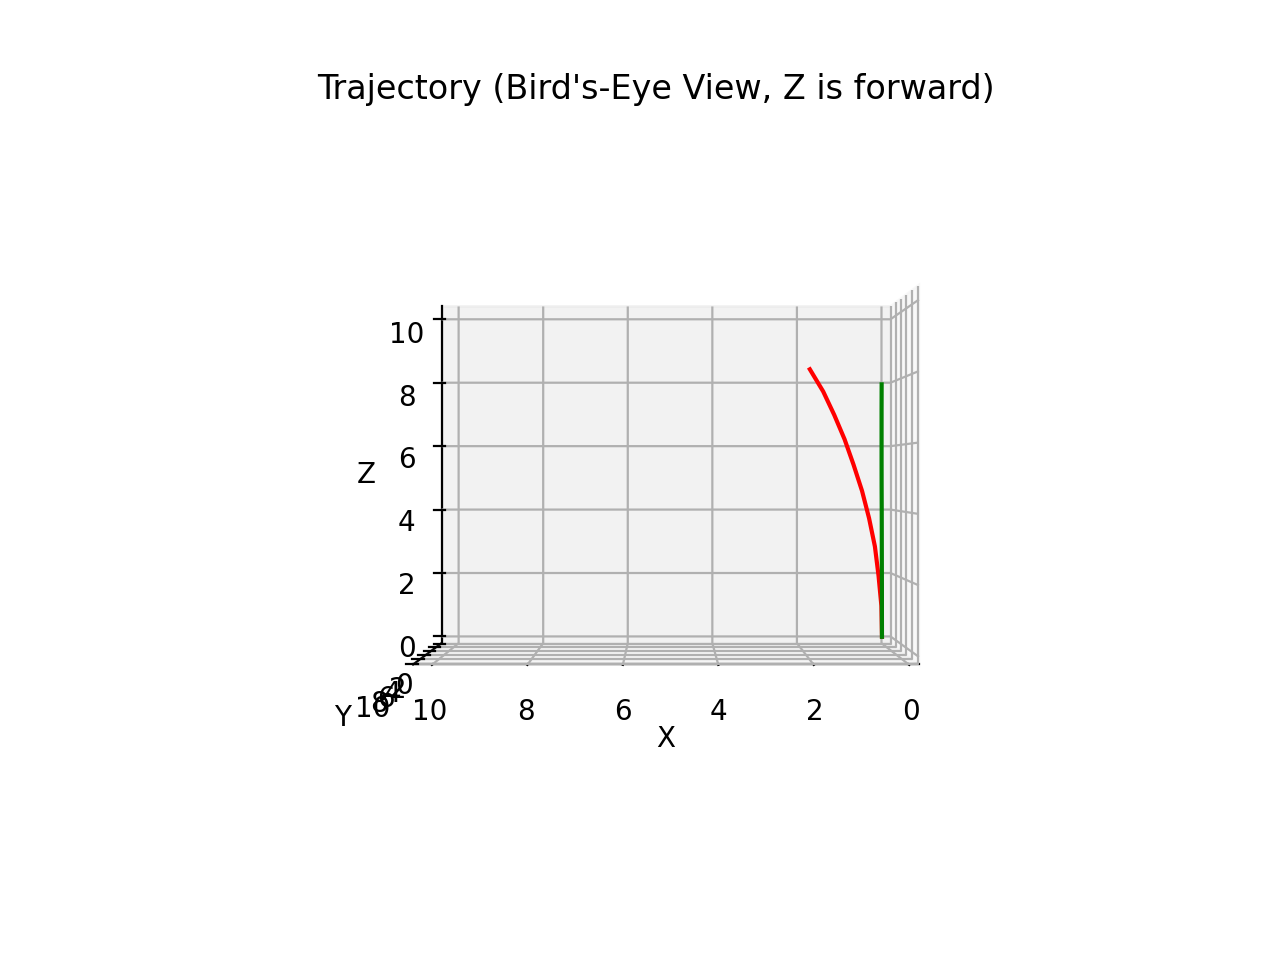

In [31]:
def plot_trajectory(ax, poses, scale_factor=1.0, line_color='r', arrow_color='b', arrow_size=5, arrow_prop=5):
    XYZ = np.array([P @ np.array([[0,0,0,1]]).transpose() for P in poses]).squeeze(axis=2)
    UVW = np.array([normalize(P @ np.array([[0,0,1,1]]).transpose()) * arrow_size for P in poses]).squeeze(axis=2)
    
    XYZ *= scale_factor
    UVW *= scale_factor

    MIN = 0
    MAX = np.max([np.max(XYZ), *ax.get_xlim(), *ax.get_ylim(), *ax.get_zlim()]) * 1.10

#     ax.quiver(
#         XYZ[::arrow_prop, 0], XYZ[::arrow_prop, 1], XYZ[::arrow_prop, 2],
#         UVW[::arrow_prop, 0], UVW[::arrow_prop, 1], UVW[::arrow_prop, 2], color=arrow_color)
    ax.plot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], line_color)

    ax.set_xlim(MIN, MAX)
    ax.set_ylim(MIN, MAX)
    ax.set_zlim(MIN, MAX)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
plot_trajectory(ax, poses)
plot_trajectory(ax, ground_truth_poses[:len(poses)], 0.60, 'g', 'g')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)
ax.set_title("Trajectory (Bird's-Eye View, Z is forward)")
plt.show()

In [26]:
len(poses)

11